## PLEASE ENABLE GPU RUNTIME IN COLAB

In [1]:
!pip install face_alignment ffmpeg-python pyyaml==5.1.2 pydub

     |████████████████████████████████| 266kB 9.2MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1.2-cp36-cp36m-linux_x86_64.whl size=44104 sha256=4a45415cee444618ec182e526b022c824e74b722e4afc73156a34af1fd227cc2
  Stored in directory: /root/.cache/pip/wheels/d9/45/dd/65f0b38450c47cf7e5312883deb97d065e030c5cca0a365030
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!git clone https://github.com/speech-separation-hse/video-features

Cloning into 'video-features'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 38 (delta 10), reused 24 (delta 3), pack-reused 0
Unpacking objects: 100% (38/38), done.


In [3]:
mv video-features/ video_features

In [4]:
!sudo apt-get install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 59 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 1s (1,641 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-p

In [5]:
!git clone -b experiments/audio_visual_sum https://github.com/speech-separation-hse/TIME-DOMAIN-AUDIO-VISUAL-SPEECH-SEPARATION

Cloning into 'TIME-DOMAIN-AUDIO-VISUAL-SPEECH-SEPARATION'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 167 (delta 24), reused 53 (delta 10), pack-reused 89
Receiving objects: 100% (167/167), 111.63 MiB | 36.11 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [6]:
!mv TIME-DOMAIN-AUDIO-VISUAL-SPEECH-SEPARATION/ separator

In [8]:
import sys
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math
import os
import numpy as np
import time
from video_features.model import LipNet
import torch.optim as optim
import re
import json
import tempfile
import shutil
import cv2
import face_alignment
import matplotlib.pyplot as plt
import uuid
from tqdm import tqdm, trange
from pathlib import Path
from joblib import Parallel, delayed
from time import perf_counter
import subprocess
import ffmpeg

import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
sys.path.insert(0, "separator/src")

In [12]:
from data_loader import audio_reader
import os
import torch
from torch.nn.parallel import data_parallel
from model.model_rnn import Dual_RNN_model
from logger.set_logger import setup_logger
import logging
from config.option import parse

In [13]:
from video_features.demo import get_position, transformation_from_points

In [14]:
opt = __import__('video_features.options')
model = LipNet()
model = model.cuda()
model.eval()
net = nn.DataParallel(model).cuda()

if(hasattr(opt, 'weights')):
    pretrained_dict = torch.load(opt.weights)
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict.keys() and v.size() == model_dict[k].size()}
    missed_params = [k for k, v in model_dict.items() if not k in pretrained_dict.keys()]
    print('loaded params/tot params:{}/{}'.format(len(pretrained_dict),len(model_dict)))
    print('miss matched params:{}'.format(missed_params))
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    

In [15]:
file = "separator/br8k.mp4"

In [16]:
p = tempfile.mkdtemp()

stream = ffmpeg.input(file, nostdin=None)
stream = ffmpeg.output(stream, f'{p}/%d.jpg', **{'qscale:v': 2, 'r':25}, loglevel="quiet")

try:
    out, err = ffmpeg.run(stream)
except:
    print("FFMPEG CRASHED")
    sys.exit(1)

if err:
    print(err)
    sys.exit(1)

files = os.listdir(p)
files = sorted(files, key=lambda x: int(os.path.splitext(x)[0]))

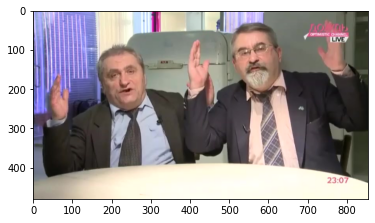

In [17]:
plt.imshow(cv2.cvtColor(cv2.imread(os.path.join(p, '1.jpg')), cv2.COLOR_BGR2RGB))

In [18]:
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False, device=f'cuda:{0}')
points = fa.get_landmarks_from_directory(p, show_progress_bar=True)
points = sorted(points.items(), key=lambda x: int(Path(x[0]).stem))

100%|██████████| 164/164 [00:10<00:00, 15.52it/s]


## ATTENTION! 
In the next cell you must change lines 13, 16 to separate faces on the video. You can get information about desired values on the picture above/

In [20]:
videos = [[], []]

front256 = get_position(256)
for filename, point_faces in tqdm(points):
    first_was_here, second_was_here = False, False
    for point in point_faces:        
        if first_was_here and second_was_here:
            print("Too many faces")
            break
        if 100 < max(point[:, 0]) < 420:
            idx = 0
            first_was_here = True
        elif max(point[:, 0]) > 450:
            idx = 1
            second_was_here = True
        else:
            continue
        if(point is not None):
            shape = np.array(point)
            shape = shape[17:]
            M = transformation_from_points(np.matrix(shape), np.matrix(front256))

            img = cv2.warpAffine(cv2.imread(filename), M[:2], (256, 256))
            (x, y) = front256[-20:].mean(0).astype(np.int32)
            w = 160//2
            img = img[y-w//2:y+w//2,x-w:x+w,...]
            img = cv2.resize(img, (128, 64))
            videos[idx].append(img)
        elif videos:
            videos[idx].append(videos[idx][-1])
        else:
            print("First frame is missing", file)
            
    if not first_was_here:
        print('first none', filename)
    if not second_was_here:
        print('second none', filename)
    
if not videos[idx]:
    print("No faces in video")
    sys.exit(1)
        
for idx in range(2):
    videos[idx] = np.stack(videos[idx], axis=0).astype(np.float32)
    videos[idx] = torch.FloatTensor(videos[idx].transpose(3, 0, 1, 2)) / 255.0

 69%|██████▉   | 113/164 [00:01<00:00, 81.50it/s]

Too many faces
Too many faces
Too many faces


 80%|███████▉  | 131/164 [00:01<00:00, 81.59it/s]

Too many faces
Too many faces
Too many faces
Too many faces
Too many faces
Too many faces
Too many faces
Too many faces


100%|██████████| 164/164 [00:02<00:00, 80.87it/s]


Too many faces
Too many faces


In [21]:
face0_features = model(videos[0][None,...].cuda(), return_video_features=True).detach()

In [22]:
face1_features = model(videos[1][None,...].cuda(), return_video_features=True).detach()

In [23]:
reader = audio_reader.get_default_audio_reader()

In [24]:
mix_audio = reader.load(file)

In [25]:
mix_audio = reader.to_tensor(mix_audio)

In [26]:
mix_audio.shape

torch.Size([1, 52224])

In [27]:
opt = parse('separator/src/config/Dual_RNN/train.yaml')

In [28]:
opt['Dual_Path_RNN']['upsample_size'] = mix_audio.shape[1] - 1

In [29]:
net = Dual_RNN_model(**opt['Dual_Path_RNN'])

In [31]:
!wget https://github.com/speech-separation-hse/TIME-DOMAIN-AUDIO-VISUAL-SPEECH-SEPARATION/raw/experiments/audio_visual_sum/src/checkpoints/Dual_Path_RNN_audio_visual_noise/best.pt

--2020-06-24 22:22:35--  https://github.com/speech-separation-hse/TIME-DOMAIN-AUDIO-VISUAL-SPEECH-SEPARATION/raw/experiments/audio_visual_sum/src/checkpoints/Dual_Path_RNN_audio_visual_noise/best.pt
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/speech-separation-hse/TIME-DOMAIN-AUDIO-VISUAL-SPEECH-SEPARATION/experiments/audio_visual_sum/src/checkpoints/Dual_Path_RNN_audio_visual_noise/best.pt [following]
--2020-06-24 22:22:36--  https://media.githubusercontent.com/media/speech-separation-hse/TIME-DOMAIN-AUDIO-VISUAL-SPEECH-SEPARATION/experiments/audio_visual_sum/src/checkpoints/Dual_Path_RNN_audio_visual_noise/best.pt
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)

In [33]:
dicts = torch.load('best.pt', map_location='cpu')
net.load_state_dict(dicts["model_state_dict"])

<All keys matched successfully>

In [34]:
net = net.to('cuda')

In [35]:
net.eval()

Dual_RNN_model(
  (audio_encoder): AudioEncoder(
    (conv1d): Conv1d(1, 256, kernel_size=(2,), stride=(1,), bias=False)
  )
  (video_encoder): VideoEncoder(
    (conv1d): Conv1d(1, 256, kernel_size=(8,), stride=(4,), bias=False)
    (upsample): Upsample(size=52223, mode=nearest)
    (prelu): PReLU(num_parameters=1)
  )
  (separation): Dual_Path_RNN(
    (audio_norm): GroupNorm(1, 256, eps=1e-08, affine=True)
    (audio_conv1d): Conv1d(256, 64, kernel_size=(1,), stride=(1,), bias=False)
    (video_norm): GroupNorm(1, 256, eps=1e-08, affine=True)
    (video_conv1d): Conv1d(256, 64, kernel_size=(1,), stride=(1,), bias=False)
    (dual_rnn): ModuleList(
      (0): Dual_RNN_Block(
        (intra_rnn): LSTM(64, 128, batch_first=True, bidirectional=True)
        (inter_rnn): LSTM(64, 128, batch_first=True, bidirectional=True)
        (intra_norm): GroupNorm(1, 64, eps=1e-08, affine=True)
        (inter_norm): GroupNorm(1, 64, eps=1e-08, affine=True)
        (intra_linear): Linear(in_features

In [36]:
with torch.no_grad():
    batch = {"mix_audios": mix_audio.cuda(),
             "first_videos_features": face0_features.transpose(1, 0).cuda(),
             "second_videos_features": face1_features.transpose(1, 0).cuda(),
             "mix_noised_audios": mix_audio.cuda()}
    res = net(batch)

In [37]:
import librosa

In [38]:
for idx, s in enumerate(res):
    os.makedirs('output_audio/', exist_ok=True)
    filename="output_audio/"+f'test_{idx}.wav'
    librosa.output.write_wav(filename, s.detach().cpu().numpy().T, opt['datasets']['audio_setting']['sample_rate'])

In [39]:
!ffmpeg -hide_banner -loglevel panic -i $file -i output_audio/test_0.wav -c:v copy -map 0:v:0 -map 1:a:0 first_speaker.mp4 -y

In [40]:
!ffmpeg -hide_banner -loglevel panic -i $file -i output_audio/test_1.wav -c:v copy -map 0:v:0 -map 1:a:0 second_speaker.mp4 -y

In [41]:
from IPython.display import HTML
from base64 import b64encode

In [44]:
mp4 = open(file,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<h1>ORIGINAL</h1>
<video width=800 controls>
      <source src="%s" type="video/mp4">

</video>
""" % data_url)

In [45]:
mp4 = open('first_speaker.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<h1>First speaker</h1>
<video width=800 controls>
      <source src="%s" type="video/mp4">

</video>
""" % data_url)

In [47]:
mp4 = open('second_speaker.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<h1>SECOND SPEAKER</h1>
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)